# Data Summary

## SCAN TYPES

The data given is a single brain with various different types of MRI scans done on it to portray different information about the brain.

### T1

This scan is a basic MRI which takes into account all the general signals the MRI can detect. This causes the image to be a little fuzzy due to the fluid motion in the brain. 

### T2

This scan focuses on the fluid regions of the brains by scanning in a manner which makes them much brighter in comparison to the brain matter areas. These scans help identify edema or inflammation in the brain. 

> Edema is when too much fluid is trapped in the body tissue

### FRAIR

This scan focuses on the brain matter, muscle tissue, and solid regions of the brain to identify physical deformations such as tumors or lesions. (What are MS Plaques)

### T1CE

An agent is applied to make areas of blood-brain barrier disruptors more apparent so that region of tumors and inflammation appear more bright. (Do not fully understand yet)

### SEGMENTATION

This are labeled regions of the brain that have been identified/segmented for analysis due to abnormalities observed during the scan. 

**These were most likely used as training data for a model to identify the points where abnormalities occured in the brain so that more subtle abnormalities could be detected??????????** 

**For out purposes of brain slice generation, would this be helpful???**


# Bugs

1. Whenever I set slice_idx=0 the animation does not update the data based on the frame (I need to find out why)

2. My code still outputs blank images after execution, I believe it is due to the animation module finishing; however, I am not sure. 

3. NamesTempFile argument delete must be set to False on Windows machines (Noted for future reference)

# Other

- .nii: NeuroImaging Informatics
- Data is stored in memory, written to disk, then reread from disk into memory
- Takes a **FAT** minute to load


Fetching file: BraTS20_Training_369_flair.nii


MovieWriter imagemagick unavailable; using Pillow instead.


Temporary file created: C:\Users\zaaim\AppData\Local\Temp\tmpyv6_qo6y.nii
Data shape for BraTS20_Training_369_flair.nii: (240, 240, 155)
Temporary file created: C:\Users\zaaim\AppData\Local\Temp\tmpdldbnyec.png
Saving BraTS20_Training_369_flair.nii.gif
Deleted temporary file: C:\Users\zaaim\AppData\Local\Temp\tmpyv6_qo6y.nii
Fetching file: BraTS20_Training_369_seg.nii


MovieWriter imagemagick unavailable; using Pillow instead.


Temporary file created: C:\Users\zaaim\AppData\Local\Temp\tmpc02gp_bw.nii
Data shape for BraTS20_Training_369_seg.nii: (240, 240, 155)
Temporary file created: C:\Users\zaaim\AppData\Local\Temp\tmpojbk3tlz.png
Saving BraTS20_Training_369_seg.nii.gif
Deleted temporary file: C:\Users\zaaim\AppData\Local\Temp\tmpc02gp_bw.nii
Fetching file: BraTS20_Training_369_t1.nii


MovieWriter imagemagick unavailable; using Pillow instead.


Temporary file created: C:\Users\zaaim\AppData\Local\Temp\tmp1ols2lj7.nii
Data shape for BraTS20_Training_369_t1.nii: (240, 240, 155)
Temporary file created: C:\Users\zaaim\AppData\Local\Temp\tmpmcolen5y.png
Saving BraTS20_Training_369_t1.nii.gif
Deleted temporary file: C:\Users\zaaim\AppData\Local\Temp\tmp1ols2lj7.nii
Fetching file: BraTS20_Training_369_t1ce.nii


MovieWriter imagemagick unavailable; using Pillow instead.


Temporary file created: C:\Users\zaaim\AppData\Local\Temp\tmpqvj_vtkh.nii
Data shape for BraTS20_Training_369_t1ce.nii: (240, 240, 155)
Temporary file created: C:\Users\zaaim\AppData\Local\Temp\tmpnyuo7uk0.png
Saving BraTS20_Training_369_t1ce.nii.gif
Deleted temporary file: C:\Users\zaaim\AppData\Local\Temp\tmpqvj_vtkh.nii
Fetching file: BraTS20_Training_369_t2.nii


MovieWriter imagemagick unavailable; using Pillow instead.


Temporary file created: C:\Users\zaaim\AppData\Local\Temp\tmp5_03zn91.nii
Data shape for BraTS20_Training_369_t2.nii: (240, 240, 155)
Temporary file created: C:\Users\zaaim\AppData\Local\Temp\tmpyf8eq50t.png
Saving BraTS20_Training_369_t2.nii.gif
Deleted temporary file: C:\Users\zaaim\AppData\Local\Temp\tmp5_03zn91.nii


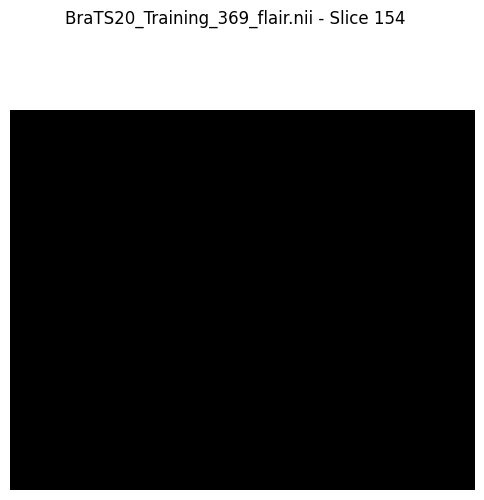

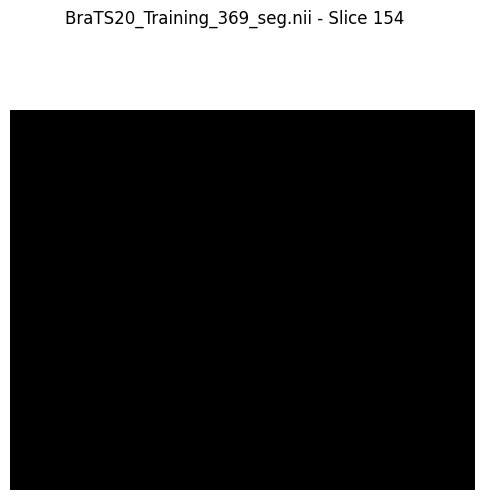

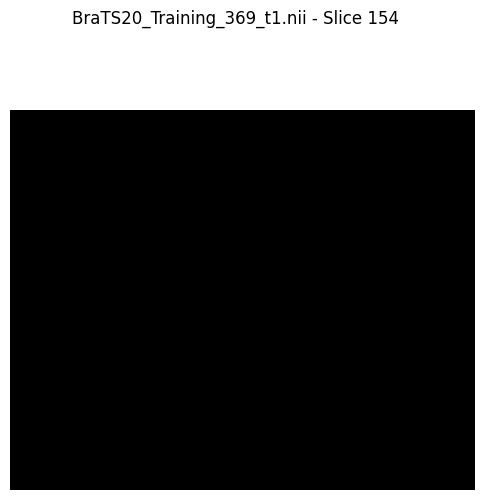

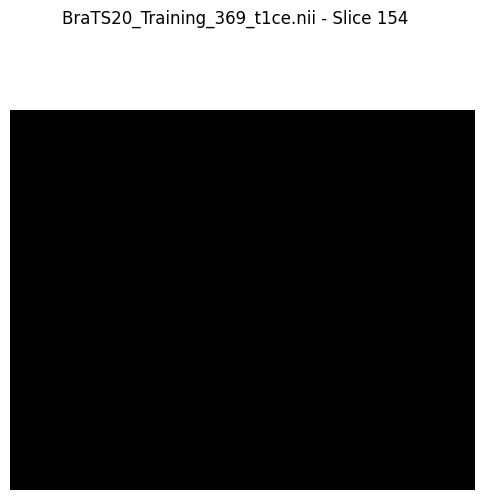

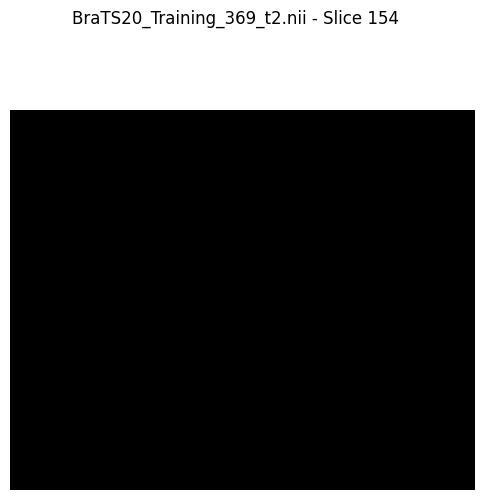

In [ ]:

import boto3
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import io
import tempfile
import os
import traceback

# Identifying resource type
s3 = boto3.resource('s3')

# Specifying resource location on AWS
bucket_name = 'chemocraft-data'
folder_path = 'Data/BraTS20_Training_369 copy/'
user='Zaaim'

# Requesting the  corresponding bucket from AWS
bucket = s3.Bucket(bucket_name)

# Setting local directory name to store brain visualizations. 
visualizer_folder = 'brain_visualizations'

# Defining function to take a specified file from s3 bucket and manipulate it locally for analysis
def render_nii_from_s3(filename):

    # Notify fetch
    print(f"Fetching file: {filename}")

    # Grab object stored in s3 bucket
    obj = bucket.Object(folder_path + filename)

    # Create stream to body of the object in s3 buckets
    file_stream = io.BytesIO(obj.get()['Body'].read())

    # Auto resource release for temporary file used to hold the binary stream data 
    with tempfile.NamedTemporaryFile(suffix='.nii', delete=False) as temp_file:  # Disable auto-delete
        
        # Wrtie to temporary file the file stream data
        temp_file.write(file_stream.getvalue())

        # Flush stream buffer
        temp_file.flush()

        # grab the file from the tempfile path (Can be source of error on Windows machines)
        temp_file_path = temp_file.name
        print(f"Temporary file created: {temp_file_path}")

    try:
        # Loading the temp file from disk into img which has header and body data of the file type
        img = nib.load(temp_file_path)
        data = img.get_fdata() # Grab the body section of the data (as ndarray)

        # Check the dimensions of the data
        print(f"Data shape for {filename}: {data.shape}")

        # Data does not exist in the .nii file
        if data.size == 0:
            print(f"No data found in {filename}")
            return

        # Setting crop variables (Pixels from edges)
        cropleft=27
        cropright=17
        cropbottom=40
        croptop=40


        slice_idx = data.shape[2] // 2 # When set to zero the function animation does not work??????

        # Initialize figure with a single Axes of size 6, 6
        fig, ax = plt.subplots(figsize=(6, 6))

        # Grab the Axis returned by setting ax Axes to imshow data display
        imgdisplay = ax.imshow(data[croptop:data.shape[1]-cropbottom, cropleft:data.shape[0]-cropright, slice_idx], cmap="grey") # Could change to other formats for visualization

        # Set the figure super title to slice indx
        fig.suptitle(f'{filename} - Slice {slice_idx}')
        plt.axis('off')  # Hide axes for cleaner display

        # Create directory for brain slices
        slice_save_dir=f"brain_slices/{filename.split(".")[0]}/";

        try:
            os.makedirs(slice_save_dir, exist_ok=True) # The filename .nii is taken out
        except e:
            print(f"ERROR: directory could not be made due to {e}")
           
        
        with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as png_upload:
        
            print(f"Temporary file created: {png_upload.name}")

        try:    
            # Update animation to increment slice of the image
            def update(frame):
                if frame<0 or frame>=data.shape[2]: # Check if image out of range
                    return imgdisplay # return previous indx

                # Remove the title of the figure
                imgdisplay.figure.suptitle("")

                # Save image slice
                plt.savefig(png_upload.name, format="png", bbox_inches='tight', pad_inches=0);
                bucket.upload_file(png_upload.name, f"{user}/{slice_save_dir}/{frame}.png")

                # Update the Axes to have the next slice data
                imgdisplay.set_data(data[croptop:data.shape[1]-cropbottom, cropleft:data.shape[0]-cropright, frame])
                # Update the title of the figure
                imgdisplay.figure.suptitle(f'{filename} - Slice {frame}')
                return imgdisplay

            # Create the animation object of the slices
            ani = animation.FuncAnimation(fig=fig, func=update, frames=data.shape[2], interval=50)
            print(f"Saving {filename}.gif")

            # Save visualization of the brain animation to specified path

            with tempfile.NamedTemporaryFile(suffix=".gif", delete=False) as vis_upload:
                ani.save(vis_upload.name, writer="imagemagick")
                bucket.upload_file(vis_upload.name, f"{user}/{visualizer_folder}/video_{filename.split(".")[0]}.gif")

            
        except e:
            print("Error occured during processing")
        finally: 
            try:
                os.remove(png_upload.name);
                print(f"Deleted temporary file: {png_upload.name}")
            except e:
                print("Failed to delete temporary png_upload file")

    except Exception as e:
        print(f"Error loading file {filename}: {e}")
        traceback.print_exc()
    finally:
        try:
            os.remove(temp_file_path)  # Clean up the temp file
            print(f"Deleted temporary file: {temp_file_path}")
        except OSError as cleanup_error:
            print(f"Error deleting temp file: {cleanup_error}")

# Iterating through objects in s3 Bucket for brain 20
found_files = False
for obj in bucket.objects.filter(Prefix=folder_path):
    if obj.key.endswith('.nii'):
        found_files = True
        filename = obj.key.split('/')[-1]  # Get the filename
        render_nii_from_s3(filename)

if not found_files:
    print(f"No .nii files found in the folder {folder_path}")


